In [1]:
import numpy as np
from scipy.stats import norm
from scipy.stats import kendalltau 
from scipy.stats import rankdata
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def fit_xgb_model(x, y):
    model = XGBRegressor()
    model.fit(x, y)
    return model

def fit_rf_model(x, y):
    model = RandomForestRegressor()
    model.fit(x, y)
    return model

def generate_data(n, m, mu):
    x = np.random.multivariate_normal(mean, M, n)
    x_unlabel = np.random.multivariate_normal(mean, M, m)
    eps = 0.05 * np.random.normal(0, 1, n)
    y = mu + x[:,0] + x[:,1] + eps
    return x, x_unlabel, y

# parameters
mean = (0, 0, 0, 0)
M = np.diag(0.3 * np.ones(4)) + 0.7 * np.ones((4, 4))

m = 50000
n = 2500

def run_experiment(seed, mu):  
    x, x_unlabel, y = generate_data(n,m,mu)
     
    # Split the data in half for training and testing
    n_half = n // 2
    m_half = m // 2
    
    x_a, x_b, y_a, y_b = (
        x[:n_half], x[n_half:], y[:n_half], y[n_half:]
    )
    x_unlabel_a, x_unlabel_b = (
        x_unlabel[:m_half], x_unlabel[m_half:]
    )
    
    ell1 = 1 - np.sum((y[:, None] <= -y), axis=0) / len(y)
    ell1_a = 1 - np.sum((y_a[:, None] <= -y_a), axis=0) / len(y_a)
    ell1_b = 1 - np.sum((y_b[:, None] <= -y_b), axis=0) / len(y_b)
    ell1_cross = np.concatenate((ell1_a, ell1_b))
     
    ## model 1
    # full
    model_full = fit_rf_model(x, ell1)
    fhat_label = model_full.predict(x)
    fhat_unlabel = model_full.predict(x_unlabel)
    
    # split a
    model_a = fit_rf_model(x_a, ell1_a)
    fhat_label_b = model_a.predict(x_b)
    fhat_unlabel_b = model_a.predict(x_unlabel_b)
    
    # split b
    model_b = fit_rf_model(x_b, ell1_b)
    fhat_label_a = model_b.predict(x_a)
    fhat_unlabel_a = model_b.predict(x_unlabel_a)
    
    fhat_label_cross = np.concatenate((fhat_label_a, fhat_label_b))
    fhat_label_unlabel_cross = np.concatenate((fhat_label_cross, fhat_unlabel_a, fhat_unlabel_b))
    
    # stats
    y_abs = np.abs(y)
    R = rankdata(y_abs)
    U = (np.sum(R * np.sign(y)) / 2 + n * (n + 1) / 4 - np.sum(y > 0)) * 2 / n / (n - 1)
        
    # Semi-supervised Wilcoxon
    wilcoxon_SS_full = U - 2 * np.mean(fhat_label) + 2 * np.mean(np.concatenate((fhat_label, fhat_unlabel)))
    wilcoxon_SS_cross = U - 2 * np.mean(fhat_label_cross) + 2 * np.mean(fhat_label_unlabel_cross)
    
    sig2_cross_null = 4 / 12 + 4 * m / (n+m) * (np.var(fhat_label_cross - ell1_cross) - 1 / 12) 
    sig2_full_null = 4 / 12 + 4 * m / (n+m) * (np.var(fhat_label - ell1) - 1 / 12)
    
    result1 = np.sum(R * np.sign(y)) / np.sqrt(n * (n + 1) * (2 * n + 1) / 6)
    result2 = np.sqrt(n) * (wilcoxon_SS_full - 1/2) / np.sqrt(sig2_full_null)
    result3 = np.sqrt(n) * (wilcoxon_SS_cross - 1/2) / np.sqrt(sig2_cross_null)
    
    ## model 2
    # full
    model_full = fit_xgb_model(x, ell1)
    fhat_label = model_full.predict(x)
    fhat_unlabel = model_full.predict(x_unlabel)
    
    # split a
    model_a = fit_xgb_model(x_a, ell1_a)
    fhat_label_b = model_a.predict(x_b)
    fhat_unlabel_b = model_a.predict(x_unlabel_b)
    
    # split b
    model_b = fit_xgb_model(x_b, ell1_b)
    fhat_label_a = model_b.predict(x_a)
    fhat_unlabel_a = model_b.predict(x_unlabel_a)
    
    fhat_label_cross = np.concatenate((fhat_label_a, fhat_label_b))
    fhat_label_unlabel_cross = np.concatenate((fhat_label_cross, fhat_unlabel_a, fhat_unlabel_b))
    
    # Semi-supervised Wilcoxon
    wilcoxon_SS_full = U - 2 * np.mean(fhat_label) + 2 * np.mean(np.concatenate((fhat_label, fhat_unlabel)))
    wilcoxon_SS_cross = U - 2 * np.mean(fhat_label_cross) + 2 * np.mean(fhat_label_unlabel_cross)
    
    sig2_cross_null = 4 / 12 + 4 * m / (n+m) * (np.var(fhat_label_cross - ell1_cross) - 1 / 12) 
    sig2_full_null = 4 / 12 + 4 * m / (n+m) * (np.var(fhat_label - ell1) - 1 / 12)
    
    result4 = np.sqrt(n) * (wilcoxon_SS_full - 1/2) / np.sqrt(sig2_full_null)
    result5 = np.sqrt(n) * (wilcoxon_SS_cross - 1/2) / np.sqrt(sig2_cross_null)
    
    return result1, result2, result3, result4, result5


mu_values = np.array((0, 0.01, 0.02, 0.03, 0.04, 0.05))


# Initialize empty lists to store the results
result1_values = []
result2_values = []
result3_values = []
result4_values = []
result5_values = []


for mu in tqdm(mu_values):
    
    # Run the experiments and store the results
    num_iterations = 2000
    results = Parallel(n_jobs=-1)(delayed(run_experiment)(seed, mu) for seed in range(num_iterations))
    results = np.array(results)
    
    qnorm_0975 = norm.ppf(0.975)
    
    # Calculate the power for each result
    power1 = np.mean(np.abs(results[:, 0]) > qnorm_0975)
    power2 = np.mean(np.abs(results[:, 1]) > qnorm_0975)
    power3 = np.mean(np.abs(results[:, 2]) > qnorm_0975)
    power4 = np.mean(np.abs(results[:, 3]) > qnorm_0975)
    power5 = np.mean(np.abs(results[:, 4]) > qnorm_0975)
    
    result1_values.append(power1)
    result2_values.append(power2)
    result3_values.append(power3)
    result4_values.append(power4)
    result5_values.append(power5)


100%|████████████████████████████████████████████| 6/6 [28:47<00:00, 287.93s/it]


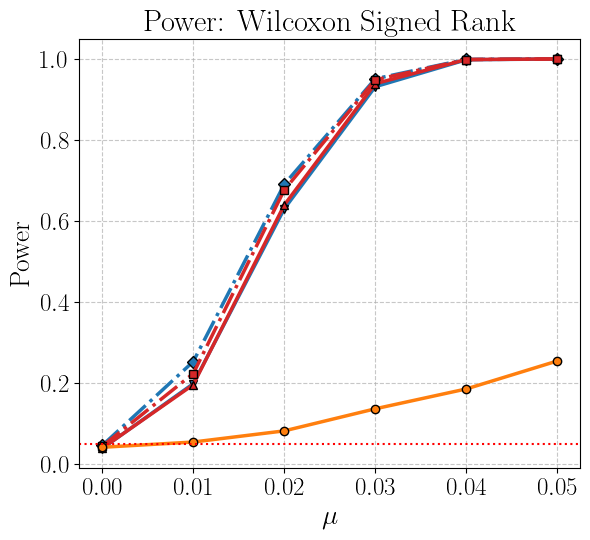

In [3]:
from matplotlib.ticker import FuncFormatter
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']


# Create the figure with a specific aspect ratio
plt.figure(figsize=(6, 5.5))

# Use consistent line styles and colors with markers
plt.plot(mu_values, result5_values, label='XGBoost ($U_{\\mathrm{cross}}$)', linewidth=2.5, linestyle='-', color=custom_palette[0], marker='v', markeredgecolor='black')
plt.plot(mu_values, result4_values, label='XGBoost ($U_{\\mathrm{plug}}$)', linewidth=2.5, linestyle='-.', color=custom_palette[0], marker='D', markeredgecolor='black')
plt.plot(mu_values, result3_values, label='RF ($U_{\\mathrm{cross}}$)', linewidth=2.5, linestyle='-', color=custom_palette[3], marker='^', markeredgecolor='black')
plt.plot(mu_values, result2_values, label='RF ($U_{\\mathrm{plug}}$)', linewidth=2.5, linestyle='-.', color=custom_palette[3], marker='s', markeredgecolor='black')
plt.plot(mu_values, result1_values, label="Wilcoxon", linewidth=2.5, linestyle='-', color=custom_palette[1], marker='o', markeredgecolor='black')

plt.xlabel('$\\mu$', fontsize=20)
plt.ylabel('Power', fontsize=20)
plt.title("Power: Wilcoxon Signed Rank", fontsize=22)  # Add a title


# Set y-axis ticks starting at y=1 with appropriate increments
plt.axhline(y=0.05, color='red', linestyle=':', label='Baseline at y=1')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=18)
plt.xticks([0, 0.01, 0.02, 0.03, 0.04, 0.05], fontsize=18)


# Use a professional LaTeX font style
plt.rc('text', usetex=True)
plt.rc('font', family='serif', serif='Computer Modern')

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)


# Save the figure in high-resolution (e.g., PDF) for the research paper
plt.tight_layout()
plt.savefig('power_wilcoxon.pdf', format='pdf', dpi=300)

plt.show()